# Importando bibliotecas

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
import umap

from src.preprocess.sequence_preprocessor import SequencePreprocessor
from src.graphing.temporal_threshold import TemporalThreshold

from notebooks.utils.view_network import plot_graph

d:\Vertis\alarm-monitor\alarm_correlation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv('data/raw/active_alarms_prod.csv')
prepocessor = SequencePreprocessor()
df = prepocessor.select_features(df)

nodes_df = prepocessor.group_by(df)

threshold = pd.Timedelta(minutes=5)
graphs_list = []
temporal_threshold = TemporalThreshold()
for node_df in nodes_df:
    graph = temporal_threshold.graph_by_key(node_df, 'Alert Type', threshold=threshold)
    graphs_list.append(graph)

In [9]:
entire_graph = nx.compose_all(graphs_list)

In [11]:
node2vec = Node2Vec(entire_graph, dimensions=64, walk_length=30, num_walks=200)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

model.save("data/models/node2vec_01.model")

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:01<00:00, 129.25it/s]


In [12]:
from gensim.models import Word2Vec

model = Word2Vec.load("data/models/node2vec_01.model")

In [24]:
nodes = list(entire_graph.nodes())
embeddings = np.array([model.wv[str(node)] for node in nodes])

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

d:\Vertis\alarm-monitor\alarm_correlation\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [70]:
target_node = "OPENSHIFT_CLUSTER_PVC"

most_similar_nodes = model.wv.most_similar(target_node, topn=1)

def get_least_similar(all_nodes, target_node, amount=1):
    similarities = []

    for node in all_nodes:
        node_str = str(node)
        if node_str != str(target_node) and node_str in model.wv:
            sim = model.wv.similarity(str(target_node), node_str)
            similarities.append((node_str, sim))

    similarities_sorted = sorted(similarities, key=lambda x: x[1])
    return similarities_sorted[:amount]

least_similar_nodes = get_least_similar(model.wv.index_to_key, target_node)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3812\524359738.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


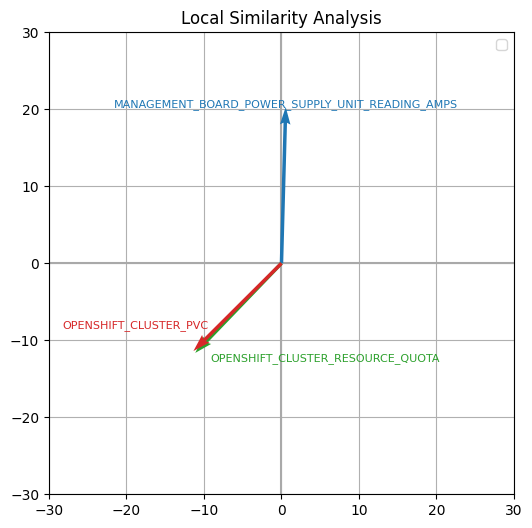

In [71]:
node_to_index = {str(node): i for i, node in enumerate(nodes)}

target_idx = node_to_index[target_node]

similar_idxs = [node_to_index[node] for node, _ in most_similar_nodes]
least_idxs = [node_to_index[node] for node, _ in least_similar_nodes]

plt.figure(figsize=(6,6))

plt.quiver(
    0, 0,
    embeddings_2d[target_idx, 0],
    embeddings_2d[target_idx, 1],
    angles='xy',
    scale_units='xy',
    scale=1,
    color="tab:red",
    zorder=5
)

for idx in similar_idxs:
    plt.quiver(
        0, 0,
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        angles='xy',
        scale_units='xy',
        scale=1,
        color="tab:green",
        zorder=4
    )

# LEAST SIMILAR (azul)
for idx in least_idxs:
    plt.quiver(
        0, 0,
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        angles='xy',
        scale_units='xy',
        scale=1,
        color="tab:blue",
        zorder=3
    )

plt.text(
    embeddings_2d[target_idx,0] + 2,
    embeddings_2d[target_idx,1] + 3,
    target_node,
    fontsize=8,
    color="tab:red",
    ha='right'
)

for node, sim in most_similar_nodes:
    idx = node_to_index[node]
    
    plt.text(
        embeddings_2d[idx,0] + 2,
        embeddings_2d[idx,1] - 1,
        node,
        fontsize=8,
        color="tab:green"
    )

for node, sim in least_similar_nodes:
    idx = node_to_index[node]
    
    plt.text(
        embeddings_2d[idx,0],
        embeddings_2d[idx,1],
        node,
        fontsize=8,
        color="tab:blue",
        ha='center'
    )

plt.xlim(-30,30)
plt.ylim(-30,30)
plt.axhline(0, color='darkgray')
plt.axvline(0, color='darkgray')
plt.grid(True, zorder=0)
plt.legend()
plt.title("Local Similarity Analysis")
plt.show()

In [66]:
most_similar_nodes = model.wv.most_similar(target_node, topn=10)

most_similar_df = pd.DataFrame(most_similar_nodes, columns=['Node', 'Similarity'])
most_similar_df

,Node,Similarity
0,OPENSHIFT_CLUSTER_RESOURCE_QUOTA,0.992048
1,OPENSHIFT_CLUSTER_NAMESPACE_MEMORY_LIMIT_PERCENT,0.991818
2,OPENSHIFT_CLUSTER_DEPLOYMENT_MEMORY_LIMITS_PER...,0.988905
3,OPENSHIFT_CLUSTER_NAMESPACE_CPU_LIMIT_PERCENT,0.980339
4,OPENSHIFT_CLUSTER_DEPLOYMENT_CPU_LIMITS_PERCENT,0.939746
5,THREESCALE_API_MANAGER_BACKEND_CALL_PROCESSING,0.565584
6,THREESCALE_CLUSTER_OPENSHIFT_UNREACHABLE,0.559128
7,DRUID_QUERY_TIMEMILLES_TOTAL,0.542706
8,CONNECTIVITY_INTERFACE_STATE_TX_USED_PERCENT,0.504379
9,SGBD_UNREACHABLE,0.475191


In [73]:
least_similar_nodes = get_least_similar(model.wv.index_to_key ,target_node, amount=10)

least_similar_df = pd.DataFrame(least_similar_nodes, columns=['Node', 'Similarity'])
least_similar_df

,Node,Similarity
0,MANAGEMENT_BOARD_POWER_SUPPLY_UNIT_READING_AMPS,-0.324152
1,NIFI_UNREACHABLE,-0.319149
2,TESTE_MONITORAMENTO_CUSTOMIZADO,-0.130615
3,PROMETHEUS_UNREACHABLE,-0.078820
4,CUSTOM_MONITORING_PROMETHEUS_MISSING_METRIC,-0.048324
5,DRUID_USED_MEMORY,-0.046805
6,JVM_DISK_USAGE,-0.041880
7,MANAGEMENT_BOARD_BATTERY_STATUS,0.003061
8,URA_DISPONIBILIDADE_VOCALIZAÇÃO,0.006519
9,JVM_MEMORY_HEAP,0.036209
